Hannah's notebook to mess around with GCNs for lorenz. WORK IN PROGRESS. (My computer broke so I have to use the computer lab and save all my incremental changes somewhere.)

### imports


In [4]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

# libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Dense

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.metrics import RootMeanSquaredError, MeanSquaredError
from spektral.layers import GCNConv, GlobalSumPool
from spektral.models import GCN
from spektral.data import MixedLoader
from lorenz import lorenzDataset, plot_with_predictions

### prepare data


In [5]:
DEFAULT_TIME_RESOLUTION = 0.01

THINGS TO TRY 
write helper functions! 
- play with diff sample size (500) - v
- input/output day ratio - h 
- play around with buffer - v
- activation layers - h
- play with the hidden layers - v 
- diff data samples / diff lorenz params - h 
- diff optimizer alg - v 

In [8]:
# TODO: add logging to see progress
dataset = lorenzDataset(
    n_samples=100,
    input_steps=5 / DEFAULT_TIME_RESOLUTION,  # 2 days
    output_delay=1 / DEFAULT_TIME_RESOLUTION,  # 1 day
    output_steps=1,
    min_buffer=10,
    rand_buffer=False,
    K=36,
    F=8,
    c=10,
    b=10,
    h=1,
    coupled=True,
    time_resolution=DEFAULT_TIME_RESOLUTION,
    seed=42)

In [9]:
# inspect dataset
print(dataset)
print(dataset[0])

lorenzDataset(n_graphs=100)
Graph(n_nodes=36, n_node_features=1000, n_edge_features=None, n_labels=1)


In [10]:
# split test/train data
# we can't use the keras split_dataset() function here because our Dataset
# class is incompatible
# we also cannot shuffle our data
train = dataset[:int(0.7 * dataset.n_graphs)]
val = dataset[int(0.7 * dataset.n_graphs):int(0.9 * dataset.n_graphs)]
test = dataset[int(0.9 * dataset.n_graphs):]

train_loader = MixedLoader(dataset=train, batch_size=32)
val_loader = MixedLoader(dataset=val, batch_size=32)
test_loader = MixedLoader(dataset=test, batch_size=32)

In [11]:
# normalize the data using the training set's mean and stdev
# TODO: verify that get_mean_std() is actually correct
X1_mean, X1_std, X2_mean, X2_std = train.get_mean_std()
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)

train.normalize(X1_mean, X1_std, X2_mean, X2_std)
val.normalize(X1_mean, X1_std, X2_mean, X2_std)
test.normalize(X1_mean, X1_std, X2_mean, X2_std)

X1_mean 2.366337151371561
X1_std 3.5351438259326553
X2_mean 0.08382469050951195
X2_std 0.251667216236199


In [12]:
# check that the normalization was successful, i.e. the train data should have
# a mean of exactly 0 and a stdev of exactly 1; val and test should have means
# near 0 and stdevs near 1
X1_mean, X1_std, X2_mean, X2_std = train.get_mean_std()
print('statistics for train set')
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)

X1_mean, X1_std, X2_mean, X2_std = val.get_mean_std()
print('\nstatistics for val set')
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)

X1_mean, X1_std, X2_mean, X2_std = test.get_mean_std()
print('\nstatistics for test set')
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)


statistics for train set
X1_mean -1.2750170831864106e-16
X1_std 0.9999999999999996
X2_mean 3.4060937491992103e-17
X2_std 1.0

statistics for val set
X1_mean -0.00492598716724943
X1_std 0.991888623895884
X2_mean -0.00025266422361596574
X2_std 0.9609322900706312

statistics for test set
X1_mean -0.0276845913263534
X1_std 0.9794567148017548
X2_mean -0.009970516144109117
X2_std 0.9392186390487864


#### inspect our data

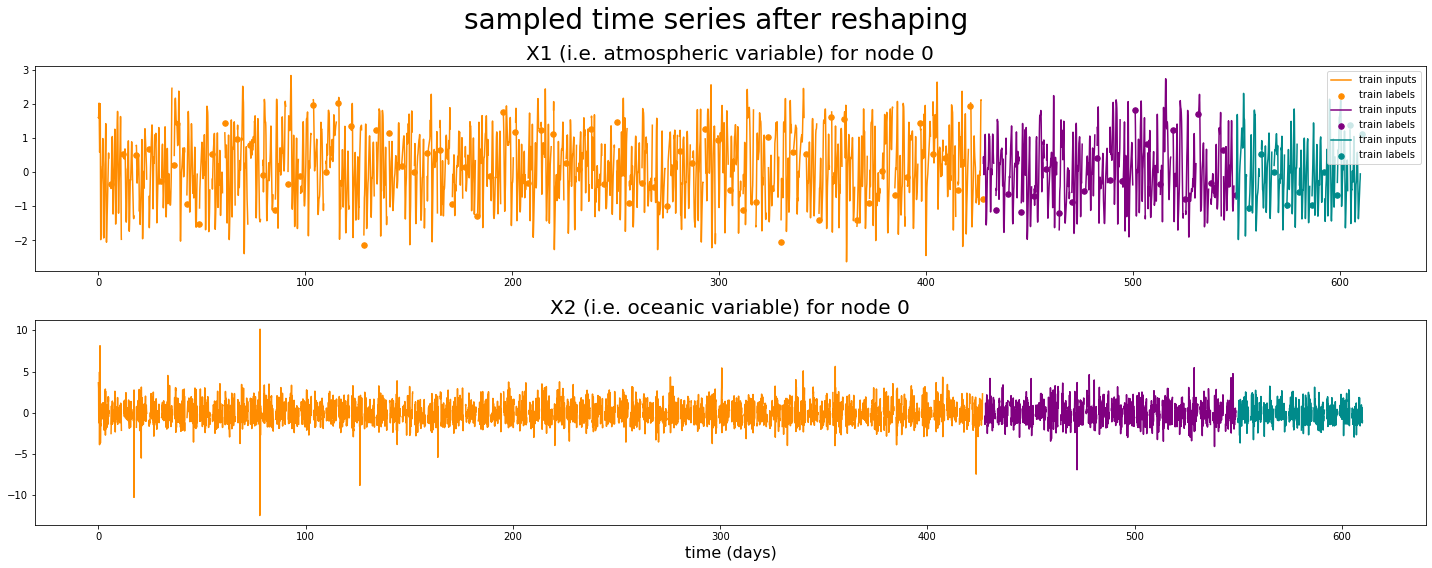

In [13]:
colors = ["darkorange", "purple", "darkcyan"]
node = 0

# set up plot
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))

fig.suptitle("sampled time series after reshaping", size=28)
ax0.set_title("X1 (i.e. atmospheric variable) for node {}".format(node),
              size=20)
ax1.set_title("X2 (i.e. oceanic variable) for node {}".format(node), size=20)
plt.xlabel('time (days)', size=16)

# plot train, val, and test data
fig, (ax0, ax1) = train.plot(node,
                             fig,
                             ax0,
                             ax1,
                             data_type='train',
                             color=colors[0])
fig, (ax0, ax1) = val.plot(node,
                           fig,
                           ax0,
                           ax1,
                           data_type='val',
                           color=colors[1])
fig, (ax0, ax1) = test.plot(node,
                            fig,
                            ax0,
                            ax1,
                            data_type='test',
                            color=colors[2])

# create legend
ax0.legend()
ax0.legend(handles=ax0.get_legend().legendHandles[0:6])
leg = ax0.get_legend()
[
    leg.legendHandles[i].set_color(colors[i // 2])
    for i in range(len(leg.legendHandles))
]

plt.tight_layout()
plt.show()

### out-of-the-box GCN

#### sanity check: initial error is reasonable

our final layer is a linear function. therefore, for the first epoch, when all our weights are initialized randomly and we set the regularization to 0, we would expect the error to be: ???

In [14]:
sanity_check_model1 = GCN(
    n_labels=1,
    channels=32,  # same thing as n_hidden
    activation="relu",
    output_activation=None,
    use_bias=False,
    dropout_rate=0,
    l2_reg=0)
sanity_check_model1.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[MeanSquaredError(), RootMeanSquaredError()])
history = sanity_check_model1.fit(train_loader.load(),
                                  steps_per_epoch=train_loader.steps_per_epoch,
                                  epochs=10)


2022-11-16 19:58:47.676122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/lib/python3.8/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'lorenzDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/10
3/3 [==============================] - 2s 6ms/step - loss: 36.0527 - mean_squared_error: 41.9624 - root_mean_squared_error: 6.4552
Epoch 2/10
3/3 [==============================] - 0s 11ms/step - loss: 13.7254 - mean_squared_error: 26.4661 - root_mean_squared_error: 5.1414
Epoch 3/10
3/3 [==============================] - 0s 9ms/step - loss: 11.8719 - mean_squared_error: 21.3825 - root_mean_squared_error: 4.6230
Epoch 4/10
3/3 [==============================] - 0s 8ms/step - loss: 8.6723 - mean_squared_error: 18.1087 - root_mean_squared_error: 4.2548
Epoch 5/10
3/3 [==============================] - 0s 8ms/step - loss: 6.0313 - mean_squared_error: 15.6847 - root_mean_squared_error: 3.9599
Epoch 6/10
3/3 [==============================] - 0s 7ms/step - loss: 5.5826 - mean_squared_error: 13.9726 - root_mean_squared_error: 3.7377
Epoch 7/10
3/3 [==============================] - 0s 8ms/step - loss: 5.0692 - mean_squared_error: 12.6674 - root_mean_squared_error: 3.5589
Epoch 8/1

#### sanity check: increasing regularization causes increasing loss

regularization reduces the amount of overfitting, thus increasing the loss on the training set

In [15]:
sanity_check_model2 = GCN(
    n_labels=1,
    channels=32,  # same thing as n_hidden
    activation="relu",
    output_activation=None,
    use_bias=False,
    dropout_rate=0.5,
    l2_reg=5e-4)
sanity_check_model2.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[MeanSquaredError(), RootMeanSquaredError()])
history = sanity_check_model2.fit(train_loader.load(),
                                  steps_per_epoch=train_loader.steps_per_epoch,
                                  epochs=10)


Epoch 1/10
3/3 [==============================] - 1s 13ms/step - loss: 58.2173 - mean_squared_error: 59.1480 - root_mean_squared_error: 7.6906
Epoch 2/10
3/3 [==============================] - 0s 12ms/step - loss: 56.6663 - mean_squared_error: 56.8987 - root_mean_squared_error: 7.5431
Epoch 3/10
3/3 [==============================] - 0s 11ms/step - loss: 49.8407 - mean_squared_error: 55.6460 - root_mean_squared_error: 7.4595
Epoch 4/10
3/3 [==============================] - 0s 11ms/step - loss: 41.7856 - mean_squared_error: 52.5814 - root_mean_squared_error: 7.2511
Epoch 5/10
3/3 [==============================] - 0s 14ms/step - loss: 40.1817 - mean_squared_error: 49.9565 - root_mean_squared_error: 7.0679
Epoch 6/10
3/3 [==============================] - 0s 14ms/step - loss: 35.3959 - mean_squared_error: 47.7116 - root_mean_squared_error: 6.9073
Epoch 7/10
3/3 [==============================] - 0s 11ms/step - loss: 35.2060 - mean_squared_error: 45.8306 - root_mean_squared_error: 6.7698

yep, the error with an L2 regularization of 5e-4 is higher than the error when the L2 regularzation was 0. 

#### sanity check 3: model can overfit

using 20 samples and setting regularization to 0, we want to make sure we can actually get to 0 error. 

(we also set dropout to 0 since dropout is supposed to help avoid overfitting.)

In [16]:
train

lorenzDataset(n_graphs=70)

In [17]:
overfit_sample = train[:20]
overfit_loader = MixedLoader(dataset=overfit_sample, batch_size=20)

sanity_check_model3 = GCN(
    n_labels=1,
    channels=32,  # same thing as n_hidden
    activation="relu",
    output_activation=None,
    use_bias=False,
    dropout_rate=0,
    l2_reg=0)
sanity_check_model3.compile(
    optimizer='adam',
    loss='mean_squared_error')
history = sanity_check_model3.fit(
    overfit_loader.load(),
    steps_per_epoch=overfit_loader.steps_per_epoch,
    epochs=2000)


Epoch 1/2000
1/1 [==============================] - 1s 599ms/step - loss: 15.0006
Epoch 2/2000
1/1 [==============================] - 0s 8ms/step - loss: 9.4383
Epoch 3/2000
1/1 [==============================] - 0s 13ms/step - loss: 7.0733
Epoch 4/2000
1/1 [==============================] - 0s 9ms/step - loss: 5.7841
Epoch 5/2000
1/1 [==============================] - 0s 17ms/step - loss: 4.9139
Epoch 6/2000
1/1 [==============================] - 0s 16ms/step - loss: 4.0558
Epoch 7/2000
1/1 [==============================] - 0s 10ms/step - loss: 3.3506
Epoch 8/2000
1/1 [==============================] - 0s 9ms/step - loss: 3.1019
Epoch 9/2000
1/1 [==============================] - 0s 18ms/step - loss: 3.0552
Epoch 10/2000
1/1 [==============================] - 0s 10ms/step - loss: 2.7298
Epoch 11/2000
1/1 [==============================] - 0s 16ms/step - loss: 2.2513
Epoch 12/2000
1/1 [==============================] - 0s 5ms/step - loss: 1.9824
Epoch 13/2000
1/1 [====================

the MSE got down to around 0.2ish by epoch 1000; however, after that, it fluctuated between  0.2 to 1 ish and didn't seem to ever get under 0.2. 

Is this good enough?

let's visualize the predictions

/opt/anaconda3/lib/python3.8/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'lorenzDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


1/1 [==============================] - 0s 197ms/step


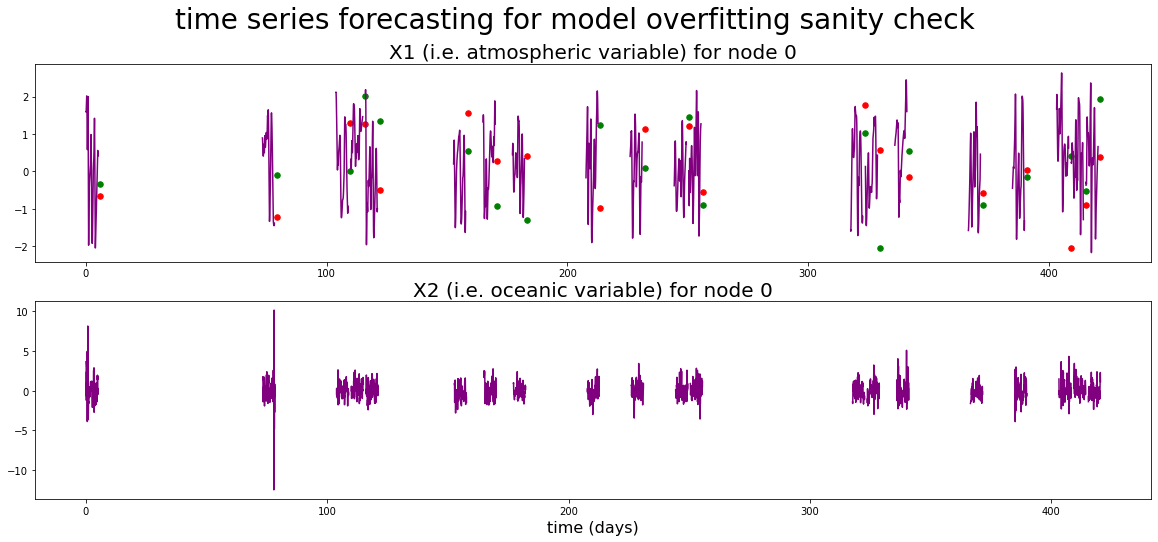

In [18]:
fig, (ax0, ax1) = plot_with_predictions(model=sanity_check_model3,
                                        graph_dataset=overfit_sample,
                                        Loader=MixedLoader,
                                        batch_size=32,
                                        node=0,
                                        model_name='overfitting sanity check')
plt.show()

### train GCN model

In [19]:
GCN_model = GCN(
    n_labels=1,
    channels=32,  # same thing as n_hidden
    activation="relu",
    output_activation=None, # we want regression, i.e. a linear function
    use_bias=False,
    dropout_rate=0,
    l2_reg=0)
GCN_model.compile(
    optimizer='adam',
    loss='mean_squared_error')
history = GCN_model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    epochs=200)

Epoch 1/200
3/3 [==============================] - 1s 24ms/step - loss: 17.6284
Epoch 2/200
3/3 [==============================] - 0s 13ms/step - loss: 12.6051
Epoch 3/200
3/3 [==============================] - 0s 14ms/step - loss: 9.4167
Epoch 4/200
3/3 [==============================] - 0s 15ms/step - loss: 6.5749
Epoch 5/200
3/3 [==============================] - 0s 12ms/step - loss: 6.0390
Epoch 6/200
3/3 [==============================] - 0s 14ms/step - loss: 5.1955
Epoch 7/200
3/3 [==============================] - 0s 13ms/step - loss: 4.1198
Epoch 8/200
3/3 [==============================] - 0s 13ms/step - loss: 3.8454
Epoch 9/200
3/3 [==============================] - 0s 13ms/step - loss: 3.6649
Epoch 10/200
3/3 [==============================] - 0s 10ms/step - loss: 3.0151
Epoch 11/200
3/3 [==============================] - 0s 12ms/step - loss: 2.7628
Epoch 12/200
3/3 [==============================] - 0s 13ms/step - loss: 2.4572
Epoch 13/200
3/3 [=============================

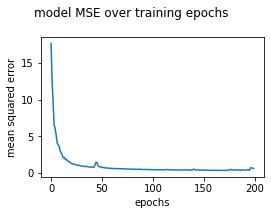

In [20]:
# print(type(history.history))
# print(history.history)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(history.history['loss'])
ax.set_ylabel('mean squared error')
ax.set_xlabel('epochs')
fig.suptitle('model MSE over training epochs')
plt.tight_layout()
plt.show()

### GCN predictions

visualize predictions on the training set

/opt/anaconda3/lib/python3.8/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'lorenzDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3/3 [==============================] - 0s 6ms/step


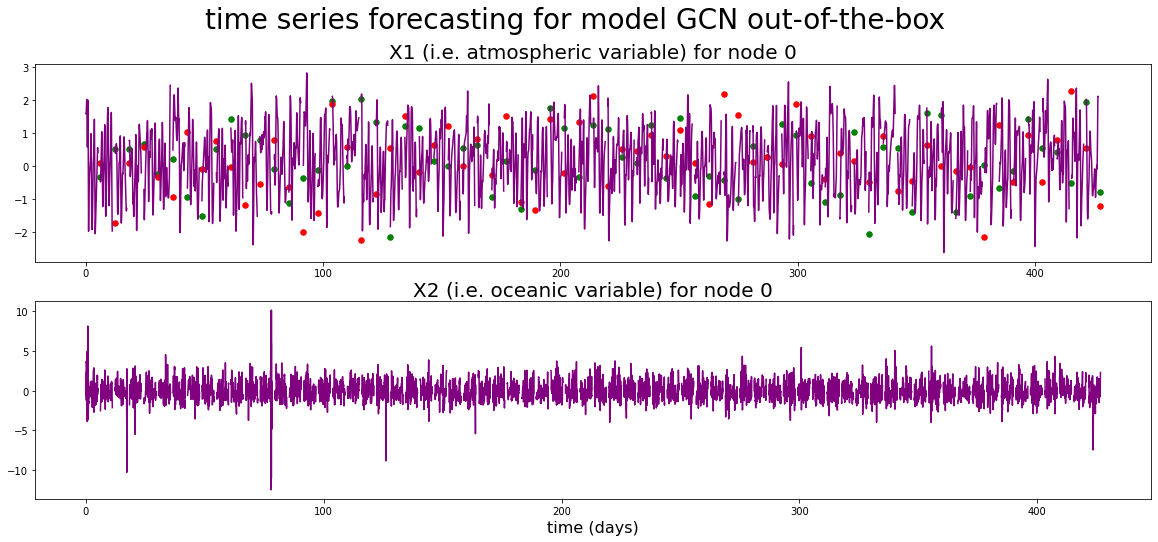

In [22]:
fig, (ax0, ax1) = plot_with_predictions(model=GCN_model,
                                        graph_dataset=train,
                                        Loader=MixedLoader,
                                        batch_size=32,
                                        node=0,
                                        model_name='GCN out-of-the-box')
plt.show()

these predictions are... pretty bad, lol

also, why are we seeing np.shuffle() being called? where is that occurring?

visualize predictions for the validation set

4/4 [==============================] - 0s 9ms/step


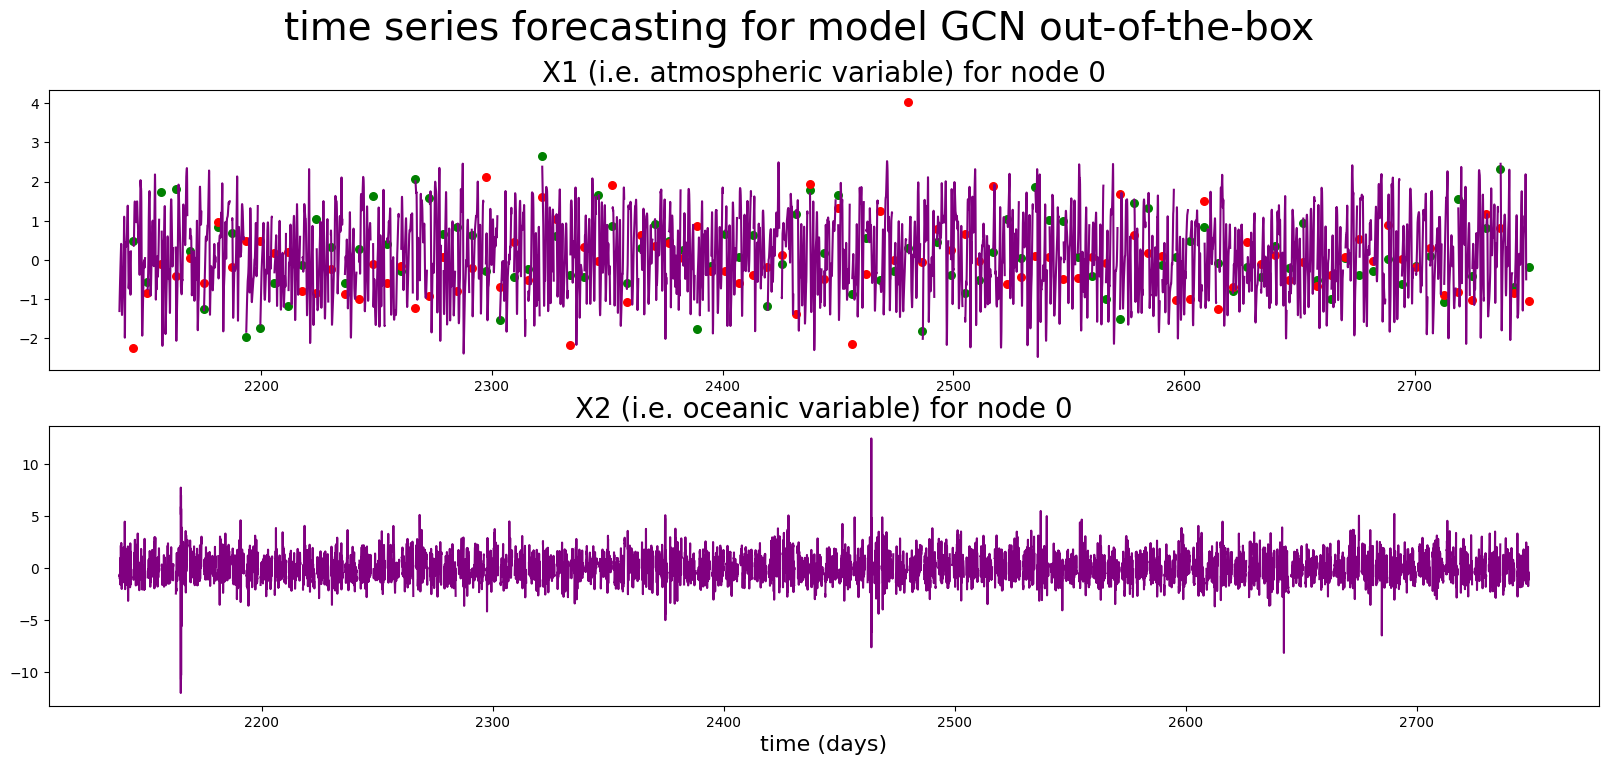

In [68]:
fig, (ax0, ax1) = plot_with_predictions(model=GCN_model,
                                        graph_dataset=val,
                                        Loader=MixedLoader,
                                        batch_size=32,
                                        node=0,
                                        model_name='GCN out-of-the-box')
plt.show()

In [ ]:
# TODO: try some different training parameters 
# TODO: try this with continuous windowing and compare this with LSTM ? 

## custom GCN

### define custom model

In [ ]:
class customGCN(Model):
    # TODO: something is going super wrong here
    def __init__(self, n_hidden, output_dim, dropout=0.5):
        super().__init__()
        self.gcn0 = GCNConv(n_hidden, activation='relu')
        self.gcn1 = GCNConv(n_hidden, activation='relu')
        self.pool = GlobalSumPool()
        self.dropout0 = Dropout(dropout)
        self.dropout1 = Dropout(dropout)
        self.dense = Dense(units=output_dim,
                           activation=None)  # linear regression layer

    def call(self, inputs):
        # print(type(inputs))
        # print(len(inputs))
        # print('\n\n')
        # print(inputs)
        x, a = inputs
        x = self.dropout0(x)
        x = self.gcn0([x, a])
        x = self.dropout1(x)
        x = self.gcn1([x, a])
        x = self.pool(x)
        out = self.dense(x)
        return out

In [ ]:
custom_model = customGCN(n_hidden=32,
                         output_dim=dataset[0].y.shape[-1],
                         dropout=0.5)
custom_model.compile(
    optimizer='adam',
    loss='mean_squared_error')
history = custom_model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    epochs=100)

Epoch 1/100
3/3 [==============================] - 1s 5ms/step - loss: 9220.6973
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 1909.1207
Epoch 3/100
3/3 [==============================] - 0s 7ms/step - loss: 2084.3423
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 2302.6650
Epoch 5/100
3/3 [==============================] - 0s 9ms/step - loss: 3120.4397
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 934.5153
Epoch 7/100
3/3 [==============================] - 0s 6ms/step - loss: 1362.0967
Epoch 8/100
3/3 [==============================] - 0s 6ms/step - loss: 1992.3489
Epoch 9/100
3/3 [==============================] - 0s 8ms/step - loss: 1355.3508
Epoch 10/100
3/3 [==============================] - 0s 6ms/step - loss: 761.1311
Epoch 11/100
3/3 [==============================] - 0s 7ms/step - loss: 1100.0125
Epoch 12/100
3/3 [==============================] - 0s 6ms/step - loss: 940.1588
Epoch 13/100
3/3 [==========